In [56]:
# ===============================================================
# ✅ STEP 1: Import Libraries
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

# Konfigurasi tampilan & style
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [57]:
# ===============================================================
# ✅ STEP 2: Buat Dataset Simulasi (Telecom Churn)
# ===============================================================

np.random.seed(42)
n = 1000

data = {
    "CustomerID": [f"CUST{i:04d}" for i in range(1, n+1)],
    "Gender": np.random.choice(["Male", "Female"], n),
    "Age": np.random.randint(18, 75, n),
    "Tenure": np.random.randint(0, 10, n),
    "ContractType": np.random.choice(["Month-to-month", "One year", "Two year"], n, p=[0.55, 0.25, 0.20]),
    "PaymentMethod": np.random.choice(["Credit Card", "Bank Transfer", "Electronic Check", "Mailed Check"], n),
    "MonthlyCharges": np.random.uniform(20, 120, n).round(2),
    "TotalCharges": np.random.uniform(100, 10000, n).round(2),
    "SatisfactionScore": np.random.randint(1, 6, n),
    "TechSupport": np.random.choice(["Yes", "No"], n, p=[0.3, 0.7]),
    "StreamingServices": np.random.choice(["Yes", "No"], n, p=[0.6, 0.4]),
    "Complaints": np.random.poisson(1, n),
    "Churn": np.random.choice([0, 1], n, p=[0.75, 0.25])
}

df = pd.DataFrame(data)
print("✅ Raw dataset created:", df.shape)
df.head()

✅ Raw dataset created: (1000, 13)


,CustomerID,Gender,Age,Tenure,ContractType,PaymentMethod,MonthlyCharges,TotalCharges,SatisfactionScore,TechSupport,StreamingServices,Complaints,Churn
0,CUST0001,Male,71,2,Month-to-month,Mailed Check,94.58,8676.30,1,Yes,Yes,1,0
1,CUST0002,Female,34,6,Month-to-month,Mailed Check,75.79,1729.82,4,Yes,No,2,0
2,CUST0003,Male,26,3,One year,Electronic Check,78.47,4209.74,5,No,No,0,0
3,CUST0004,Male,50,0,Month-to-month,Bank Transfer,33.37,241.88,4,No,No,0,1
4,CUST0005,Male,70,4,Two year,Electronic Check,64.39,4835.52,1,No,No,2,0


In [58]:
# ===============================================================
# ✅ STEP 3: Data Cleaning
# ===============================================================

# Periksa missing values awal
print("Missing values sebelum simulasi:\n", df.isnull().sum())

# Buat simulasi missing values 5% di kolom tertentu
for col in ["TotalCharges", "SatisfactionScore"]:
    df.loc[df.sample(frac=0.05).index, col] = np.nan

print("\nMissing values setelah disimulasikan:\n", df.isnull().sum())

# Tangani missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df["SatisfactionScore"].fillna(df["SatisfactionScore"].mode()[0], inplace=True)

# Hapus duplikat (jika ada)
df.drop_duplicates(inplace=True)

# Konversi tipe data churn jadi integer
df["Churn"] = df["Churn"].astype(int)

print("\n✅ Data cleaned successfully!")

Missing values sebelum simulasi:
 CustomerID           0
Gender               0
Age                  0
Tenure               0
ContractType         0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
SatisfactionScore    0
TechSupport          0
StreamingServices    0
Complaints           0
Churn                0
dtype: int64

Missing values setelah disimulasikan:
 CustomerID            0
Gender                0
Age                   0
Tenure                0
ContractType          0
PaymentMethod         0
MonthlyCharges        0
TotalCharges         50
SatisfactionScore    50
TechSupport           0
StreamingServices     0
Complaints            0
Churn                 0
dtype: int64

✅ Data cleaned successfully!


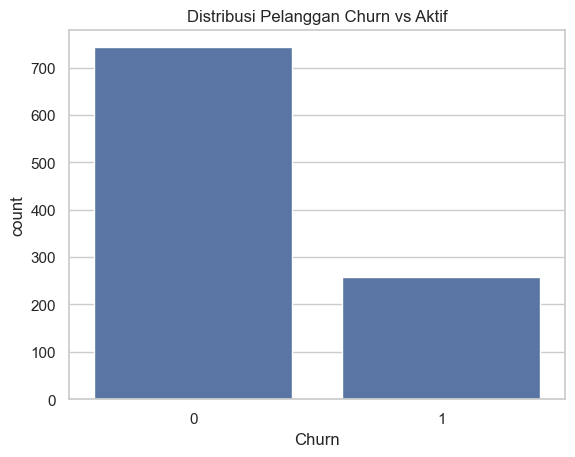

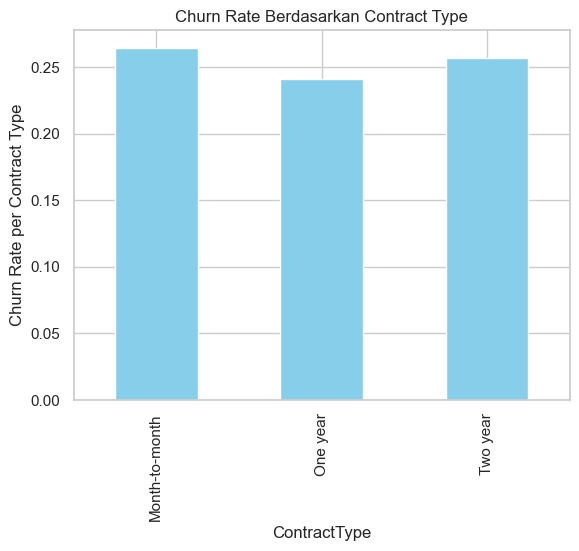

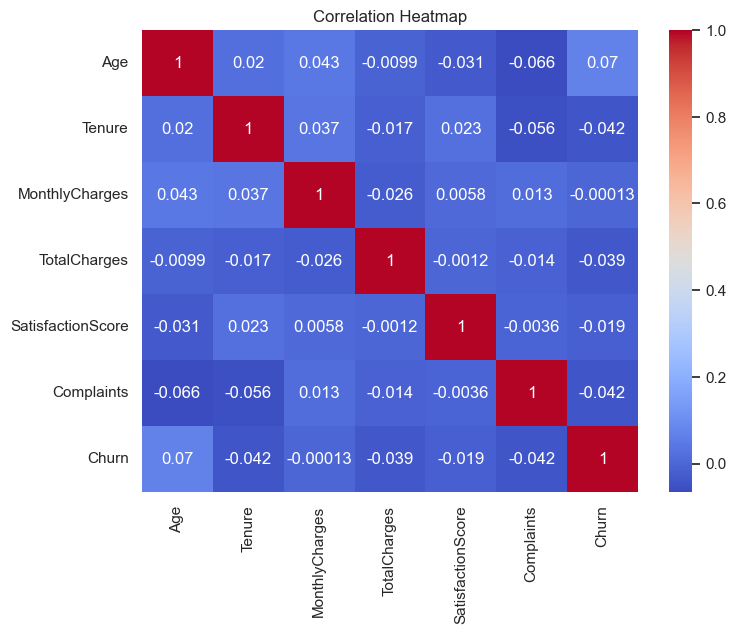

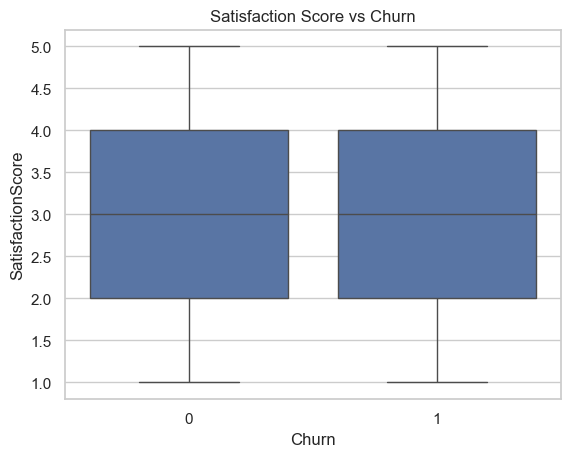

In [59]:
# ===============================================================
# ✅ STEP 4: Exploratory Data Analysis (EDA)
# ===============================================================

# Distribusi churn
sns.countplot(x="Churn", data=df)
plt.title("Distribusi Pelanggan Churn vs Aktif")
plt.show()

# Churn rate berdasarkan ContractType
churn_by_contract = df.groupby("ContractType")["Churn"].mean()
churn_by_contract.plot(kind="bar", title="Churn Rate Berdasarkan Contract Type", color="skyblue")
plt.ylabel("Churn Rate per Contract Type")
plt.show()

# Korelasi antar variabel numerik
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Boxplot Satisfaction Score vs Churn
sns.boxplot(x="Churn", y="SatisfactionScore", data=df)
plt.title("Satisfaction Score vs Churn")
plt.show()

In [61]:
# ===============================================================
# ✅ STEP 5: Feature Encoding (Benar dan Aman)
# ===============================================================

# Buat encoder berbeda untuk tiap kolom
encoders = {}
categorical_cols = ["Gender", "ContractType", "PaymentMethod", "TechSupport", "StreamingServices"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Tampilkan mapping tiap kolom
print("\n🧭 Mapping hasil LabelEncoder:")
for col, le in encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{col}: {mapping}")

# Normalisasi kolom numerik
scaler = StandardScaler()
df[["MonthlyCharges", "TotalCharges", "Age", "Tenure"]] = scaler.fit_transform(
    df[["MonthlyCharges", "TotalCharges", "Age", "Tenure"]]
)

print("\n✅ Feature encoding & scaling done!")


🧭 Mapping hasil LabelEncoder:
Gender: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
ContractType: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2)}
PaymentMethod: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3)}
TechSupport: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
StreamingServices: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}

✅ Feature encoding & scaling done!


In [62]:
# ===============================================================
# ✅ STEP 6: Modeling (Random Forest)
# ===============================================================

# Pisahkan data
X = df.drop(columns=["CustomerID", "Churn"])
y = df["Churn"]

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Buat model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi
print("\n🎯 Model Evaluation Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🎯 Model Evaluation Results:
Accuracy: 0.73

Confusion Matrix:
 [[146   3]
 [ 51   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.84       149
           1       0.00      0.00      0.00        51

    accuracy                           0.73       200
   macro avg       0.37      0.49      0.42       200
weighted avg       0.55      0.73      0.63       200



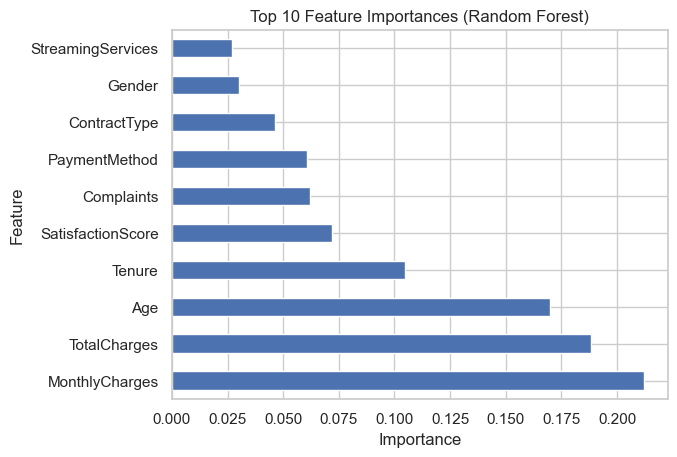

In [63]:
# ===============================================================
# ✅ STEP 7: Feature Importance
# ===============================================================

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [64]:
# ===============================================================
# ✅ STEP 8: Save Cleaned Dataset
# ===============================================================

output_path = "../data/cleaned/telecom_churn_cleaned_verified.csv"
df.to_csv(output_path, index=False)

print(f"\n💾 Cleaned dataset saved successfully at: {output_path}")
print("🏁 ALL STEPS COMPLETED SUCCESSFULLY!")



💾 Cleaned dataset saved successfully at: ../data/cleaned/telecom_churn_cleaned_verified.csv
🏁 ALL STEPS COMPLETED SUCCESSFULLY!
